## Part of Speech Tagging with Hidden Markov Models 
- 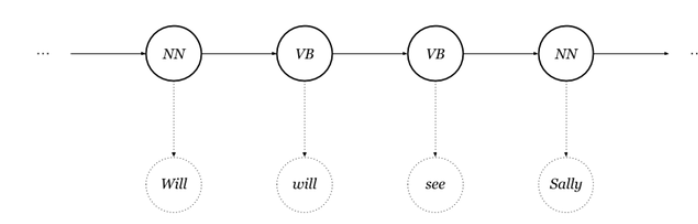

In [11]:
# http://bit.ly/313d6Sq
import matplotlib.pyplot as plt
import numpy as np
from IPython.core.display import HTML
from collections import Counter, defaultdict
from pomegranate import State, HiddenMarkovModel, DiscreteDistribution

In [12]:
%run "Helpers/helpers.py"

## Example from the Brown corpus dataset
- 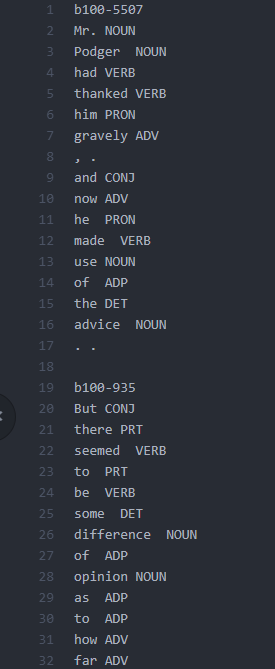

In [13]:
data = Dataset("tags-universal.txt", "brown-universal.txt", train_test_split=0.8)
print("There are {} sentences in the corpus".format(len(data)))
print("There are {} sentences in the training dataset".format(len(data.training_set)))
print("There are {} sentences in the testing dataset".format(len(data.testing_set)))

There are 57340 sentences in the corpus
There are 45872 sentences in the training dataset
There are 11468 sentences in the testing dataset


## Sentences
- `Dataset.sentences` is a dictionary of all sentences in the training corpus
- the unique sentence identifier is the key, a tuple of (words,tag) is the values

In [14]:
key = 'b100-38532'
data.sentences[key]

Sentence(words=('Perhaps', 'it', 'was', 'right', ';', ';'), tags=('ADV', 'PRON', 'VERB', 'ADJ', '.', '.'))

In [16]:
print(f"Sentence: {key}")
print(f"words:\n\t{data.sentences[key].words}")
print(f"tags:\n\t{data.sentences[key].tags}")

Sentence: b100-38532
words:
	('Perhaps', 'it', 'was', 'right', ';', ';')
tags:
	('ADV', 'PRON', 'VERB', 'ADJ', '.', '.')


## Counting Unique Elements

In [18]:
print("There are a total of {} samples of {} unique words in the corpus".format(data.N, len(data.vocab)))
print("There are {} samples of {} unique words in the training set".format(data.training_set.N, len(data.training_set.vocab)))
print("There are {} samples of {} unique words in the testing set".format(data.testing_set.N, len(data.testing_set.vocab)))
print("There are {} words in test set that are missing in the training set. ".format(len(data.testing_set.vocab - data.training_set.vocab)))

There are a total of 1161192 samples of 56057 unique words in the corpus
There are 928458 samples of 50536 unique words in the training set
There are 232734 samples of 25112 unique words in the testing set
There are 5521 words in test set that are missing in the training set. 


## Pair Counts
- computes the joint frequency counts for two input sequences.

In [23]:
def pair_counts(sequences_A, sequences_B):
    dcount = defaultdict(dict)
    d = dict(Counter(list(zip(sequences_A, sequences_B))))
    for key, value in d.items():
        dcount[key[0]][key[1]] = value
    return dcount

tags = [tag for word, tag in data.stream()]
words = [word for word, tag in data.stream()]
emmission_counts = pair_counts(tags, words)

## Most Frequent Class Tagger

In [24]:
FakeState = namedtuple("FakeState", "name")

In [25]:
class MFCTagger:
    missing = FakeState(name="<MISSING>")
    def __init__(self, table):
        self.table = defaultdict(lambda: MFCTagger.missing)
        self.table.update({word: FakeState(name=tag) for word, tag in table.items()})
        
    def viterbi(self, seq):
        """This method simplifies predictions by matching the Pomegranate viterbi() interface"""
        return 0., list(enumerate(["<start>"] + [self.table[w] for w in seq] + ["<end>"]))

In [26]:
word_counts = pair_counts(words, tags)

In [27]:
mfc_table = {}

for word in data.training_set.vocab:
    mfc_table[word] = max(word_counts[word], key = word_counts[word].get)
    
mfc_model = MFCTagger(mfc_table)

In [28]:
mfc_table

{'microphoning': 'NOUN',
 'premieres': 'NOUN',
 'Skolovsky': 'NOUN',
 'enmity': 'NOUN',
 'Frankly': 'ADV',
 'professional': 'ADJ',
 'Va.': 'NOUN',
 'worth': 'ADJ',
 '15.5': 'NUM',
 'leased': 'VERB',
 'shortened': 'VERB',
 "everybody's": 'NOUN',
 'investigative': 'ADJ',
 'quintet': 'NOUN',
 'summarizes': 'VERB',
 'preferred': 'VERB',
 'Lindskog': 'NOUN',
 'voulez': 'X',
 'superiority': 'NOUN',
 'recheck': 'VERB',
 'Confessions': 'NOUN',
 'States-Yugoslav': 'NOUN',
 '$184': 'NOUN',
 'shortest': 'ADJ',
 'rent': 'VERB',
 "Redbirds'": 'NOUN',
 'thet': 'ADP',
 'anthems': 'NOUN',
 'GE': 'NOUN',
 'kava': 'NOUN',
 'undergone': 'VERB',
 'pug-nosed': 'ADJ',
 'conceptualization': 'NOUN',
 'Washington-Oregon': 'NOUN',
 'Corrections': 'NOUN',
 'edging': 'VERB',
 'substantial': 'ADJ',
 'helmets': 'NOUN',
 'airflow': 'NOUN',
 'N.Y.U.': 'NOUN',
 'years': 'NOUN',
 'floundering': 'VERB',
 'Troy': 'NOUN',
 'disarm': 'VERB',
 'Doolin': 'NOUN',
 '$.07': 'NOUN',
 'Everywhere': 'ADV',
 'locust': 'NOUN',
 'Ter

## Making Predictions with a Model

In [29]:
def replace_unknown(sequence):
    return [w if w in data.training_set.vocab else 'nan' for w in sequence]

def simplify_decoding(X, model):
    _, state_path = model.viterbi(replace_unknown(X))
    return [state[1].name for state in state_path[1:-1]]

## Example Decoding Sequences with MFC Tagger

In [30]:
for key in data.testing_set.keys[:3]:
    print("Sentence Key: {}\n".format(key))
    print("Predicted Labels: \n-----------------")
    print(simplify_decoding(data.sentences[key].words, mfc_model))

Sentence Key: b100-28144

Predicted Labels: 
-----------------
['CONJ', 'NOUN', 'NUM', '.', 'NOUN', 'NUM', '.', 'NOUN', 'NUM', '.', 'CONJ', 'NOUN', 'NUM', '.', '.', 'NOUN', '.', '.']
Sentence Key: b100-23146

Predicted Labels: 
-----------------
['PRON', 'VERB', 'DET', 'NOUN', 'ADP', 'ADJ', 'ADJ', 'NOUN', 'VERB', 'VERB', '.', 'ADP', 'VERB', 'DET', 'NOUN', 'ADP', 'NOUN', 'ADP', 'DET', 'NOUN', '.']
Sentence Key: b100-35462

Predicted Labels: 
-----------------
['DET', 'ADJ', 'NOUN', 'VERB', 'VERB', 'VERB', 'ADP', 'DET', 'ADJ', 'ADJ', 'NOUN', 'ADP', 'DET', 'ADJ', 'NOUN', '.', 'ADP', 'ADJ', 'NOUN', '.', 'CONJ', 'ADP', 'DET', '<MISSING>', 'ADP', 'ADJ', 'ADJ', '.', 'ADJ', '.', 'CONJ', 'ADJ', 'NOUN', 'ADP', 'ADV', 'NOUN', '.']


## Evaluating Model Accuracy


In [31]:
def accuracy(X, Y, model):
    correct = total_predictions = 0
    for observations, actual_tags in zip(X, Y):
        try:
            most_likely_tags = simplify_decoding(observations, model)
            correct += sum(p == t for p, t in zip(most_likely_tags, actual_tags))
        except:
            pass
        total_predictions += len(observations)
    return correct/total_predictions

## Evaluate the accuracy of the MFC tagger

In [32]:
mfc_training_acc = accuracy(data.training_set.X, data.training_set.Y, mfc_model)
print("Training Accuracy for the MFC Model: {:.2f}%".format(100*mfc_training_acc))
mfc_testing_acc = accuracy(data.testing_set.X, data.testing_set.Y, mfc_model)
print("Testing Accuracy for the MFC Model: {:.2f}%".format(100*mfc_testing_acc))

Training Accuracy for the MFC Model: 95.71%
Testing Accuracy for the MFC Model: 93.13%


## Bigram Counts

In [33]:
import itertools
def pairwise(iterable):
    t, t_1 = itertools.tee(iterable)
    next(t_1, 'end')
    return zip(t, t_1)

def bigram_counts(sequences):
    return(dict(Counter(pairwise(sequences))))

tag_bigrams = bigram_counts(tags)

## Sequence Starting Counts

In [34]:
def starting_counts(sequences):
    return(dict(Counter(i[0] for i in sequences)))

In [35]:
tags_label = data.Y
tag_starts = starting_counts(tags_label)

In [36]:
tag_starts

{'NOUN': 8093,
 'CONJ': 2817,
 'PRT': 2103,
 'DET': 12238,
 'PRON': 9157,
 'ADP': 7044,
 'ADJ': 1969,
 'ADV': 5238,
 'VERB': 2588,
 'NUM': 964,
 '.': 5099,
 'X': 30}

## Sequence Ending Counts

In [37]:
def ending_counts(sequences):
    return(dict(Counter(i[-1] for i in sequences)))

In [39]:
tag_ends = ending_counts(tags_label)
tag_ends

{'.': 56149,
 'ADJ': 31,
 'ADV': 20,
 'NOUN': 914,
 'NUM': 80,
 'PRON': 5,
 'ADP': 8,
 'VERB': 102,
 'DET': 18,
 'PRT': 9,
 'CONJ': 2,
 'X': 2}

## Basic HMM Tagger
- Use the tag unigrams and bigrams calculated above to construct a hidden Markov tagger.

- Add one state per tag
    - The emission distribution at each state should be estimated with the formula: $P(w|t) = \frac{C(t, w)}{C(t)}$
- Add an edge from the starting state `basic_model.start` to each tag
    - The transition probability should be estimated with the formula: $P(t|start) = \frac{C(start, t)}{C(start)}$
- Add an edge from each tag to the end state `basic_model.end`
    - The transition probability should be estimated with the formula: $P(end|t) = \frac{C(t, end)}{C(t)}$
- Add an edge between _every_ pair of tags
    - The transition probability should be estimated with the formula: $P(t_2|t_1) = \frac{C(t_1, t_2)}{C(t_1)}$

In [40]:
basic_model = HiddenMarkovModel(name="base-hmm-tagger")
tags = [tag for _, tag in data.stream()]
words = [word for word, _ in data.stream()]
emission_counts = pair_counts(tags, words)
states = {}

In [44]:
def unigram_counts(sequences):

    return Counter(sequences)

tags = [tag for i, (word, tag) in enumerate(data.training_set.stream())]
tag_unigrams = unigram_counts(tags)

In [48]:
for pos_tag in data.tagset:
    emission_probabilities = dict()
    
    for word, occurence in emission_counts[pos_tag].items():
        emission_probabilities[word] = occurence/tag_unigrams[pos_tag]
    
    tag_distribution = DiscreteDistribution(emission_probabilities)
    state = State(tag_distribution, name=pos_tag)
    states[pos_tag] = state
    basic_model.add_state(state)
    
emission_probabilities

{'there': 0.05659667029197691,
 'to': 0.6166652723165732,
 'Such': 0.0015058981008951727,
 'half': 0.009704676650213335,
 'all': 0.10658412114113612,
 'up': 0.07107002426169162,
 'out': 0.06776541454028277,
 "you'll": 0.0025098301681586214,
 "It's": 0.00669288044842299,
 "kid's": 0.00012549150840793105,
 'on': 0.02325775955826989,
 'off': 0.01999498033966368,
 'down': 0.029030368945034718,
 "that's": 0.003764745252237932,
 "it's": 0.005939931397975403,
 "you'd": 0.0011712540784740233,
 "you're": 0.003890236760645863,
 'in': 0.019451183803229313,
 'over': 0.01602108257341253,
 'such': 0.01146155776792437,
 'There': 0.03392453777294403,
 "he'd": 0.0031372877101982764,
 'To': 0.010583117209068854,
 "We've": 0.0008784405588555174,
 'Sonuvabitch': 4.183050280264369e-05,
 "I'm": 0.011252405253911153,
 "That's": 0.0040575587718564374,
 "We're": 0.001087593072868736,
 'quite': 0.0017150506149083912,
 'Goodbye': 8.366100560528738e-05,
 "You're": 0.002426169162553334,
 "who's": 0.000334644022421

In [50]:
for pos_tag in data.tagset:
    state = states[pos_tag]
    tags_label = data.Y
    tag_starts = starting_counts(tags_label)
    tag_ends = ending_counts(tags_label)
    start_probability = tag_starts[pos_tag]/sum(tag_starts.values())
    basic_model.add_transition(basic_model.start, state, start_probability)
    end_probability = tag_ends[pos_tag]/sum(tag_ends.values())
    basic_model.add_transition(state, basic_model.end, end_probability)

In [53]:
for tag_1 in data.tagset:
    state_1 = states[tag_1]
    sum_of_probabilities = 0
    for tag_2 in data.tagset:
        state_2 = states[tag_2]
        bigram = (tag_1, tag_2)
        transition_probability = tag_bigrams[bigram]/tag_unigrams[tag_1]
        sum_of_probabilities += transition_probability
        basic_model.add_transition(state_1, state_2, transition_probability)

In [55]:
basic_model.bake()
print("Number of nodes or states: ", basic_model.node_count())
print("Number of edges: ", basic_model.edge_count())

Number of nodes or states:  14
Number of edges:  168


In [57]:
hmm_training_acc = accuracy(data.training_set.X, data.training_set.Y, basic_model)
print("Training Accuracy for the Basic HMM Model: {:.2f}%".format(100 * hmm_training_acc))
hmm_testing_acc = accuracy(data.testing_set.X, data.testing_set.Y, basic_model)
print("Testing Accuracy for the Basic HMM Model: {:.2f}%".format(100 * hmm_testing_acc))

Training Accuracy for the Basic HMM Model: 97.53%
Testing Accuracy for the Basic HMM Model: 96.16%


### Example Decoding Sequences with the HMM Tagger

In [59]:
for key in data.testing_set.keys[:3]:
    print("Sentence Key: {}\n".format(key))
    print("Predicted Labels:\n--------------")
    print(simplify_decoding(data.sentences[key].words, basic_model))
    print()
    print("Actual Labels:\n-----------")
    print(data.sentences[key].tags)
    print("\n")

Sentence Key: b100-28144

Predicted Labels:
--------------
['CONJ', 'NOUN', 'NUM', '.', 'NOUN', 'NUM', '.', 'NOUN', 'NUM', '.', 'CONJ', 'NOUN', 'NUM', '.', '.', 'NOUN', '.', '.']

Actual Labels:
-----------
('CONJ', 'NOUN', 'NUM', '.', 'NOUN', 'NUM', '.', 'NOUN', 'NUM', '.', 'CONJ', 'NOUN', 'NUM', '.', '.', 'NOUN', '.', '.')


Sentence Key: b100-23146

Predicted Labels:
--------------
['PRON', 'VERB', 'DET', 'NOUN', 'ADP', 'ADJ', 'ADJ', 'NOUN', 'VERB', 'VERB', '.', 'ADP', 'VERB', 'DET', 'NOUN', 'ADP', 'NOUN', 'ADP', 'DET', 'NOUN', '.']

Actual Labels:
-----------
('PRON', 'VERB', 'DET', 'NOUN', 'ADP', 'ADJ', 'ADJ', 'NOUN', 'VERB', 'VERB', '.', 'ADP', 'VERB', 'DET', 'NOUN', 'ADP', 'NOUN', 'ADP', 'DET', 'NOUN', '.')


Sentence Key: b100-35462

Predicted Labels:
--------------
['DET', 'ADJ', 'NOUN', 'VERB', 'VERB', 'VERB', 'ADP', 'DET', 'ADJ', 'ADJ', 'NOUN', 'ADP', 'DET', 'ADJ', 'NOUN', '.', 'ADP', 'ADJ', 'NOUN', '.', 'CONJ', 'ADP', 'DET', 'NOUN', 'ADP', 'ADJ', 'ADJ', '.', 'ADJ', '.', 'CO